In [44]:
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_forecast_component
from plotnine import *

# Data Loading

In [3]:
df=pd.read_csv('/home/ubuntu/code/prophet/examples/example_wp_log_peyton_manning.csv')
df.loc[:,'ds']=pd.to_datetime(df.ds,format='%Y-%m-%d')
print(df.shape)
print(df.ds.min(),df.ds.max())
df.head(5)

(2905, 2)
2007-12-10 00:00:00 2016-01-20 00:00:00


,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


# 01 Modeling Holidays and Special Events 

## 1.1 Create holiday df 

In [12]:
playoffs=pd.DataFrame({
    'holiday':'playoff',
    'ds':pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                         '2010-01-24', '2010-02-07', '2011-01-08',
                         '2013-01-12', '2014-01-12', '2014-01-19',
                         '2014-02-02', '2015-01-11', '2016-01-17',
                         '2016-01-24', '2016-02-07']),
    'lower_window':0,
    'upper_window':1,
})

superbowls=pd.DataFrame({
    'holiday':'superbowl',
    'ds':pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
    'lower_window':0,
    'upper_window':1
})
holiday=pd.concat([playoffs,superbowls])
print(holiday.shape)
holiday.head(5)

(17, 4)


,holiday,ds,lower_window,upper_window
0,playoff,2008-01-13,0,1
1,playoff,2009-01-03,0,1
2,playoff,2010-01-16,0,1
3,playoff,2010-01-24,0,1
4,playoff,2010-02-07,0,1


## 1.2 Fitting 

In [13]:
m=Prophet(holidays=holiday)
m.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [14]:
## Making future table
future=m.make_future_dataframe(periods=365)
future.tail(5)

,ds
3265,2017-01-15
3266,2017-01-16
3267,2017-01-17
3268,2017-01-18
3269,2017-01-19


## 1.3  Predicting

In [15]:
forecast=m.predict(future)
print(forecast.columns)
forecast.tail(5)

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'holidays', 'holidays_lower', 'holidays_upper', 'playoff',
       'playoff_lower', 'playoff_upper', 'superbowl', 'superbowl_lower',
       'superbowl_upper', 'weekly', 'weekly_lower', 'weekly_upper', 'yearly',
       'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3265,2017-01-15,7.204061,7.293909,8.772231,6.890094,7.544851,0.832112,0.832112,0.832112,0.0,...,0.016553,0.016553,0.016553,0.815559,0.815559,0.815559,0.0,0.0,0.0,8.036173
3266,2017-01-16,7.203080,7.732401,9.065972,6.887772,7.545686,1.167681,1.167681,1.167681,0.0,...,0.329642,0.329642,0.329642,0.838039,0.838039,0.838039,0.0,0.0,0.0,8.370761
3267,2017-01-17,7.202099,7.474961,8.856119,6.885489,7.546568,0.993733,0.993733,0.993733,0.0,...,0.133009,0.133009,0.133009,0.860724,0.860724,0.860724,0.0,0.0,0.0,8.195832
3268,2017-01-18,7.201119,7.306801,8.717103,6.883205,7.547664,0.830127,0.830127,0.830127,0.0,...,-0.053235,-0.053235,-0.053235,0.883362,0.883362,0.883362,0.0,0.0,0.0,8.031246
3269,2017-01-19,7.200138,7.379605,8.772959,6.881139,7.548545,0.846427,0.846427,0.846427,0.0,...,-0.059214,-0.059214,-0.059214,0.905641,0.905641,0.905641,0.0,0.0,0.0,8.046565


### Reviewing 

In [16]:
## Review Impact
forecast.loc[abs(forecast.playoff+forecast.superbowl)>0,['ds','playoff','superbowl']][-10:]

,ds,playoff,superbowl
2190,2014-02-02,1.220720,1.214678
2191,2014-02-03,1.901618,1.460850
2532,2015-01-11,1.220720,0.000000
2533,2015-01-12,1.901618,0.000000
2901,2016-01-17,1.220720,0.000000
2902,2016-01-18,1.901618,0.000000
2908,2016-01-24,1.220720,0.000000
2909,2016-01-25,1.901618,0.000000
2922,2016-02-07,1.220720,1.214678
2923,2016-02-08,1.901618,1.460850


In [18]:
## All special holidays
# need to test whether any date would have impact -> June 22
forecast.loc[(forecast.ds.isin(holiday.ds))|
             (abs(forecast.playoff+forecast.superbowl)>0),['ds','playoff','superbowl']]

,ds,playoff,superbowl
34,2008-01-13,1.220720,0.000000
35,2008-01-14,1.901618,0.000000
361,2009-01-03,1.220720,0.000000
362,2009-01-04,1.901618,0.000000
730,2010-01-16,1.220720,0.000000
731,2010-01-17,1.901618,0.000000
737,2010-01-25,1.901618,0.000000
750,2010-02-07,1.220720,1.214678
1076,2011-01-08,1.220720,0.000000
1077,2011-01-09,1.901618,0.000000


### Viz - Trend & Change Points - With Holiday Impact 

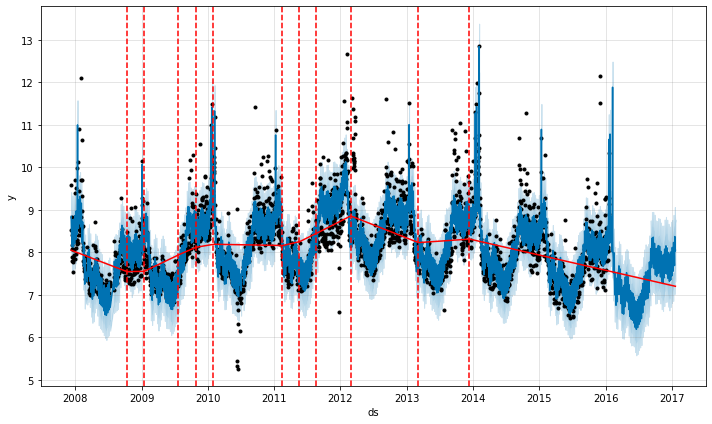

In [22]:
## Trend & change points
fig=m.plot(forecast)
a=add_changepoints_to_plot(fig.gca(),m,forecast) # only 11 change points, but 17/14 holiday inputs

In [23]:
holiday

,holiday,ds,lower_window,upper_window
0,playoff,2008-01-13,0,1
1,playoff,2009-01-03,0,1
2,playoff,2010-01-16,0,1
3,playoff,2010-01-24,0,1
4,playoff,2010-02-07,0,1
5,playoff,2011-01-08,0,1
6,playoff,2013-01-12,0,1
7,playoff,2014-01-12,0,1
8,playoff,2014-01-19,0,1
9,playoff,2014-02-02,0,1


### Viz - Components Plot 

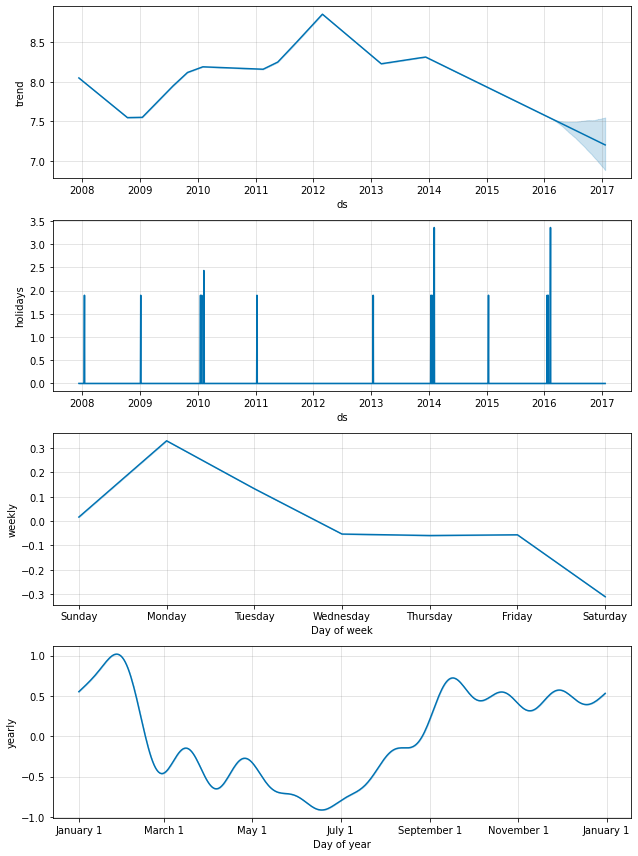

In [24]:
fig_com=m.plot_components(forecast)

### Viz - plot just holiday Components 

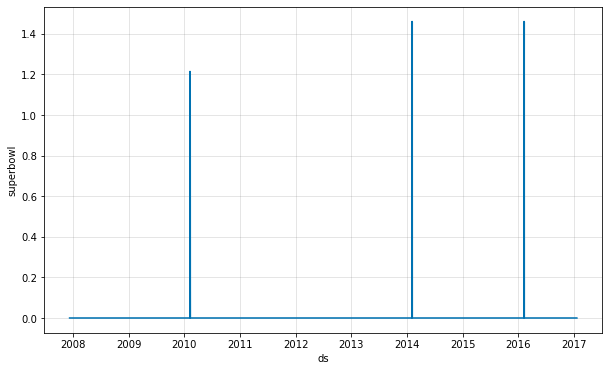

In [28]:
fig_fcom=plot_forecast_component(m,forecast,'superbowl')

## 1.4 All Holiday Effect 

### Reconfigure Holiday 

In [30]:
df

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572
...,...,...
2900,2016-01-16,7.817223
2901,2016-01-17,9.273878
2902,2016-01-18,10.333775
2903,2016-01-19,9.125871


In [33]:
holiday_all_effect=pd.DataFrame({
    'holiday':'holiday_all',
    'ds':df.ds,
    'lower_window':0,
    'upper_window':1
    })
super_all_effect=pd.DataFrame({
    'holiday':'super_all',
    'ds':df.ds,
    'lower_window':0,
    'upper_window':1
})
holiday_all=pd.concat([holiday_all_effect,super_all_effect])
print(holiday_all.shape)
holiday_all.head(5)

(5810, 4)


,holiday,ds,lower_window,upper_window
0,holiday_all,2007-12-10,0,1
1,holiday_all,2007-12-11,0,1
2,holiday_all,2007-12-12,0,1
3,holiday_all,2007-12-13,0,1
4,holiday_all,2007-12-14,0,1


### Modeling 

In [35]:
m_all_holiday=Prophet(holidays=holiday_all)
m_all_holiday.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Prediction 

In [37]:
forecast_all_holiday=m_all_holiday.predict(future)

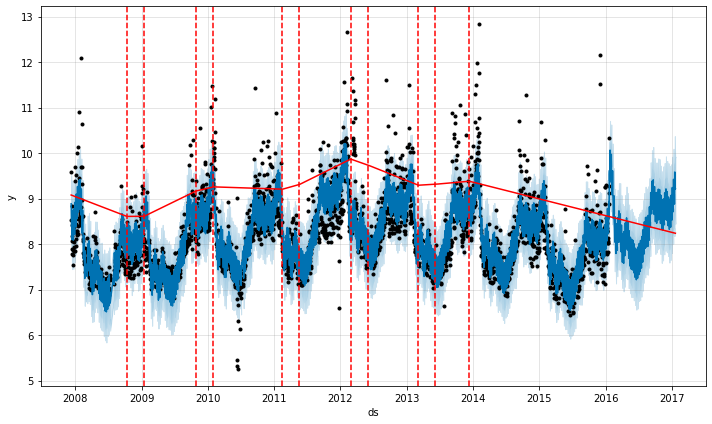

In [38]:
## Viz
fig_all_holiday=m_all_holiday.plot(forecast_all_holiday)
a_all_holiday=add_changepoints_to_plot(fig_all_holiday.gca(),
                                       m_all_holiday,
                                       forecast_all_holiday
                                      )

In [62]:
## Review
forecast_all_holiday.loc[:,['ds','holiday_all','super_all']][:10]

,ds,holiday_all,super_all
0,2007-12-10,-0.497275,-0.497275
1,2007-12-11,-0.520488,-0.520488
2,2007-12-12,-0.520488,-0.520488
3,2007-12-13,-0.520488,-0.520488
4,2007-12-14,-0.520488,-0.520488
5,2007-12-15,-0.520488,-0.520488
6,2007-12-16,-0.520488,-0.520488
7,2007-12-17,-0.520488,-0.520488
8,2007-12-18,-0.520488,-0.520488
9,2007-12-19,-0.520488,-0.520488


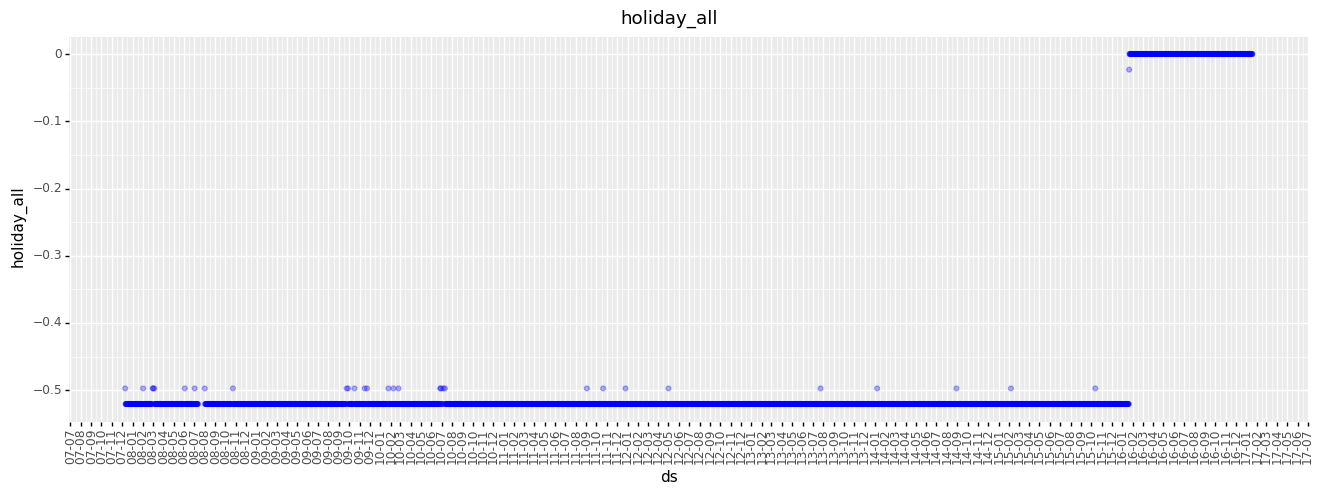

<ggplot: (8766103045289)>


In [63]:
## Viz -1
print(
    ggplot(forecast_all_holiday,aes('ds','holiday_all'))
    +geom_point(color='blue',alpha=0.3)
    +scale_x_datetime(date_breaks='1 month',date_labels='%y-%m')
    +theme(axis_text_x=element_text(angle=90),figure_size=(16,5))
    +labs(title='holiday_all')
)

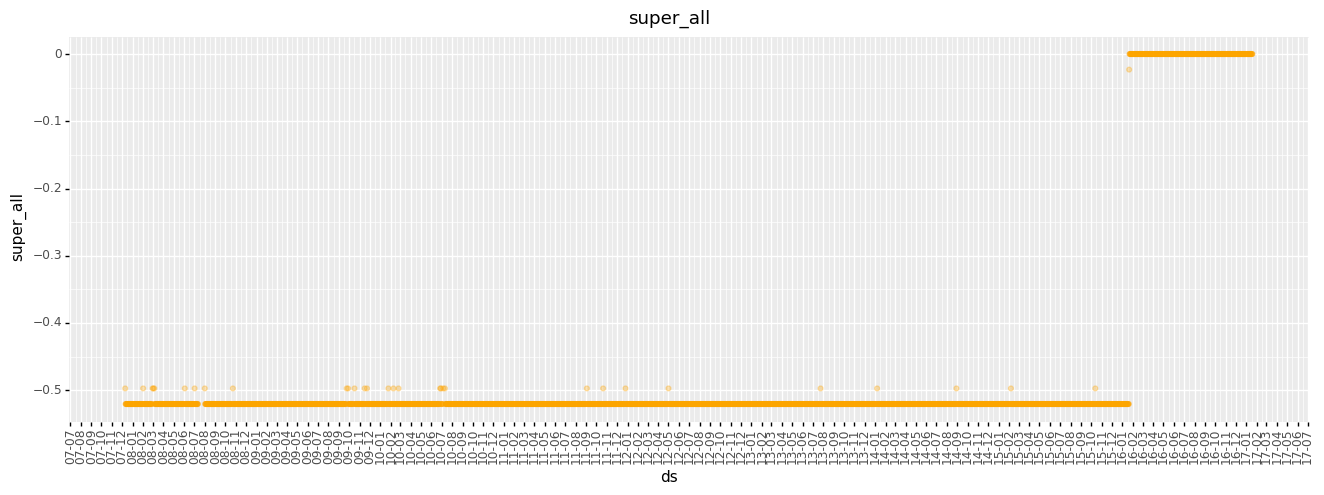

<ggplot: (8766108207761)>


In [64]:
## Viz -2
print(
    ggplot(forecast_all_holiday,aes('ds','super_all'))
    +geom_point(color='orange',alpha=0.3)
    +scale_x_datetime(date_breaks='1 month',date_labels='%y-%m')
    +theme(axis_text_x=element_text(angle=90),figure_size=(16,5))
    +labs(title='super_all')
)

In [66]:
print(forecast_all_holiday.shape)
forecast_all_holiday.loc[:,['ds','holiday_all','super_all']].groupby(['holiday_all','super_all']).size()

(3270, 28)


holiday_all  super_all
-0.520488    -0.520488    2875
-0.497275    -0.497275      30
-0.023212    -0.023212       1
 0.000000     0.000000     364
dtype: int64

In [68]:
## contribution larger than -0.5
forecast_all_holiday.loc[((forecast_all_holiday.holiday_all>-0.5)|
                         (forecast_all_holiday.super_all>-0.5))&
                         (forecast_all_holiday.holiday_all+forecast_all_holiday.super_all!=0)
                         ,['ds','holiday_all','super_all']]

,ds,holiday_all,super_all
0,2007-12-10,-0.497275,-0.497275
52,2008-02-01,-0.497275,-0.497275
79,2008-02-29,-0.497275,-0.497275
80,2008-03-02,-0.497275,-0.497275
81,2008-03-05,-0.497275,-0.497275
169,2008-06-03,-0.497275,-0.497275
197,2008-07-02,-0.497275,-0.497275
208,2008-08-01,-0.497275,-0.497275
289,2008-10-23,-0.497275,-0.497275
624,2009-09-24,-0.497275,-0.497275


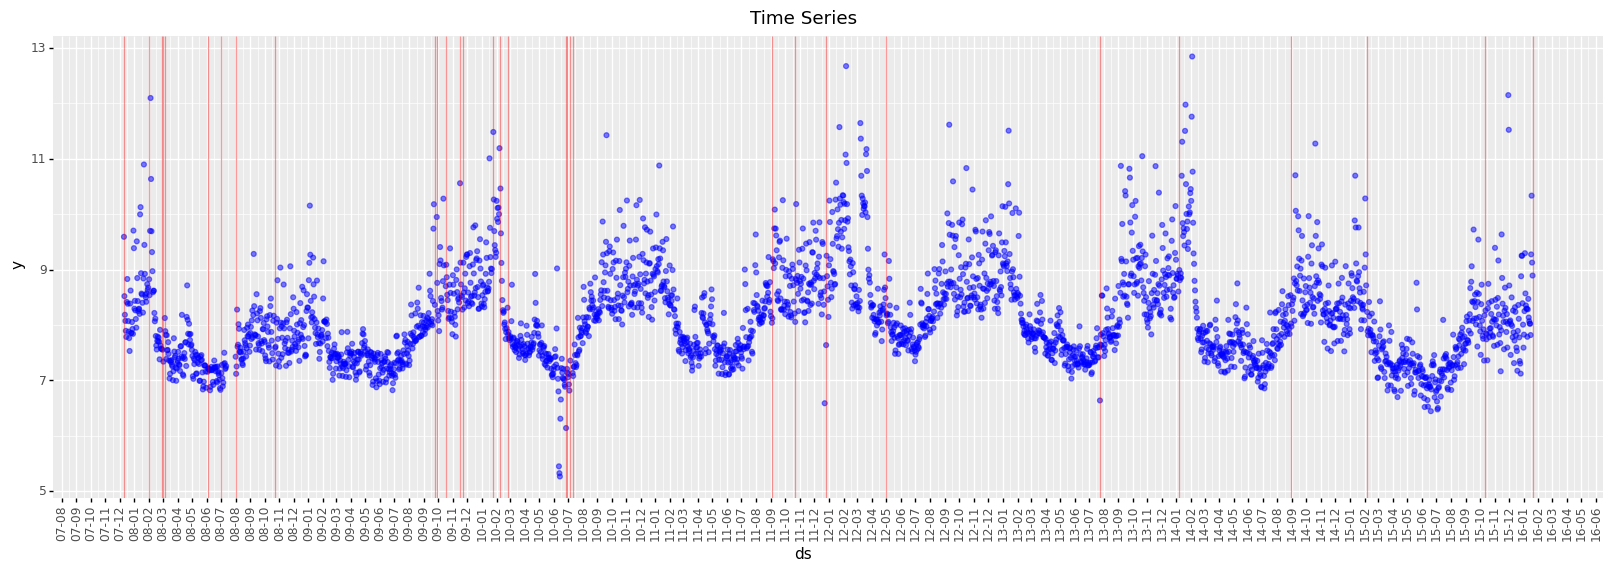

<ggplot: (8766103328139)>


In [73]:
print(
    ggplot(df,aes('ds','y'))
    +geom_point(color='blue',alpha=0.5)
    +scale_x_datetime(date_breaks='1 month',date_labels='%y-%m')
    +geom_vline(xintercept=forecast_all_holiday.loc[(forecast_all_holiday.holiday_all>-0.5)&
                                                    (forecast_all_holiday.holiday_all!=0)
                                                    ,'ds'],
                color='red',alpha=0.4)
    +theme(axis_text_x=element_text(angle=90),figure_size=(20,6))
    +labs(title='Time Series')

)

# 02 Built-in Country Holidays

## 02.1 Fitting 

In [78]:
m_cholidays=Prophet(holidays=holiday)
m_cholidays=m_cholidays.add_country_holidays(country_name='US')
m_cholidays.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [79]:
## Review holidays added
m_cholidays.train_holiday_names

0                         playoff
1                       superbowl
2                  New Year's Day
3      Martin Luther King Jr. Day
4           Washington's Birthday
5                    Memorial Day
6                Independence Day
7                       Labor Day
8                    Columbus Day
9                    Veterans Day
10                   Thanksgiving
11                  Christmas Day
12       Christmas Day (Observed)
13        Veterans Day (Observed)
14    Independence Day (Observed)
15      New Year's Day (Observed)
dtype: object

## 02.2 Predict and Review 

In [81]:
forecast_choliday=m_cholidays.predict(future)
forecast_choliday

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2007-12-10,8.048564,8.268669,9.466035,8.048564,8.048564,0.0,0.0,0.0,0.0,...,0.341369,0.341369,0.341369,0.462275,0.462275,0.462275,0.0,0.0,0.0,8.852208
1,2007-12-11,8.046944,8.005948,9.222428,8.046944,8.046944,0.0,0.0,0.0,0.0,...,0.130337,0.130337,0.130337,0.449646,0.449646,0.449646,0.0,0.0,0.0,8.626927
2,2007-12-12,8.045323,7.851166,9.024646,8.045323,8.045323,0.0,0.0,0.0,0.0,...,-0.057331,-0.057331,-0.057331,0.438364,0.438364,0.438364,0.0,0.0,0.0,8.426355
3,2007-12-13,8.043702,7.854758,9.009485,8.043702,8.043702,0.0,0.0,0.0,0.0,...,-0.056102,-0.056102,-0.056102,0.428741,0.428741,0.428741,0.0,0.0,0.0,8.416342
4,2007-12-14,8.042082,7.830156,8.981886,8.042082,8.042082,0.0,0.0,0.0,0.0,...,-0.055856,-0.055856,-0.055856,0.421040,0.421040,0.421040,0.0,0.0,0.0,8.407266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3265,2017-01-15,7.205274,7.313928,8.685317,6.892164,7.530204,0.0,0.0,0.0,0.0,...,0.012151,0.012151,0.012151,0.777906,0.777906,0.777906,0.0,0.0,0.0,7.995330
3266,2017-01-16,7.204286,8.153858,9.493993,6.888515,7.530267,0.0,0.0,0.0,0.0,...,0.341369,0.341369,0.341369,0.796994,0.796994,0.796994,0.0,0.0,0.0,8.829808
3267,2017-01-17,7.203299,7.410834,8.813007,6.884866,7.530330,0.0,0.0,0.0,0.0,...,0.130337,0.130337,0.130337,0.816995,0.816995,0.816995,0.0,0.0,0.0,8.150631
3268,2017-01-18,7.202312,7.274008,8.680420,6.881352,7.530393,0.0,0.0,0.0,0.0,...,-0.057331,-0.057331,-0.057331,0.837695,0.837695,0.837695,0.0,0.0,0.0,7.982675


### Viz 

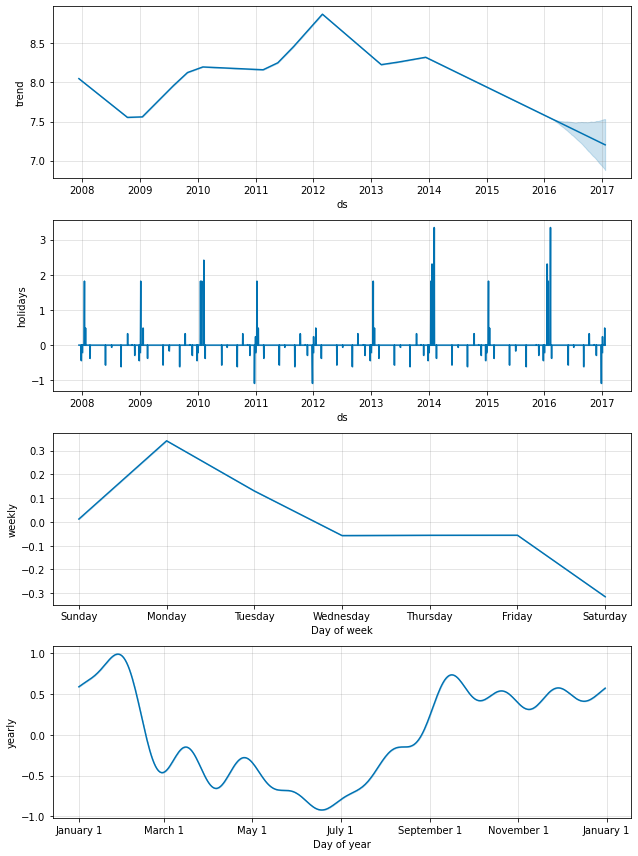

In [84]:
## Viz -1 components
fig=m_cholidays.plot_components(forecast_choliday)

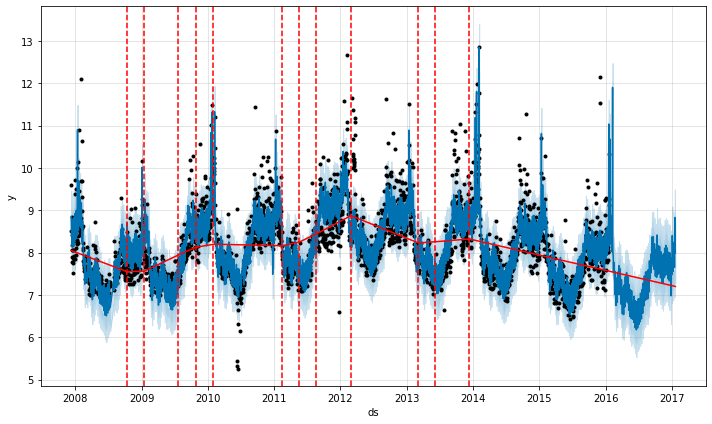

In [85]:
## Viz changepoints
fig_choliday_all=m_cholidays.plot(forecast_choliday)
a_choliday=add_changepoints_to_plot(fig_choliday_all.gca(),
                                    m_cholidays,
                                    forecast_choliday
                                   )

In [ ]:
## Need to highlight the impact of adding US holidays